<a href="https://colab.research.google.com/github/nanometre380/fgsm-faceswap/blob/main/FGSM_faceswap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 12.9 MB/s 


In [ ]:
!git clone https://github.com/DeePepper/DeePepper.git

Cloning into 'DeePepper'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 30 (delta 7), reused 6 (delta 2), pack-reused 0
Unpacking objects: 100% (30/30), done.


In [ ]:
%cd DeePepper/

/content/DeePepper


In [ ]:
!bash download.sh data

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow_addons as tfa

In [ ]:
import load_faceswap
model = load_faceswap.model

model.summary()

Model: "original"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 face_in_a (InputLayer)         [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 face_in_b (InputLayer)         [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 encoder (Functional)           (None, 8, 8, 512)    69662976    ['face_in_a[0][0]',              
                                                                  'face_in_b[0][0]']              
                                                                                                  
 decoder_a (Functional)         (None, 64, 64, 3)    6199747     ['encoder[0][0]']         

In [ ]:
model_AtoB = Sequential([
                         model.get_layer('face_in_a'),
                         model.get_layer('encoder'),
                         model.get_layer('decoder_b')
])
model_AtoB.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        (None, 8, 8, 512)         69662976  
                                                                 
 decoder_b (Functional)      (None, 64, 64, 3)         6199747   
                                                                 
Total params: 75,862,723
Trainable params: 75,862,723
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_BtoA = Sequential([
                         model.get_layer('face_in_b'),
                         model.get_layer('encoder'),
                         model.get_layer('decoder_a')
])
model_BtoA.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        (None, 8, 8, 512)         69662976  
                                                                 
 decoder_a (Functional)      (None, 64, 64, 3)         6199747   
                                                                 
Total params: 75,862,723
Trainable params: 75,862,723
Non-trainable params: 0
_________________________________________________________________


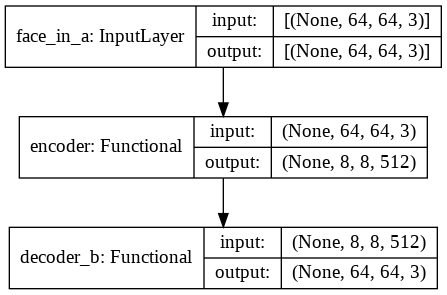

In [ ]:
tf.keras.utils.plot_model(model_AtoB, "my_second_model.png", show_shapes=True)

In [ ]:
#FGSM
class FastGradientSignMethod : 
  def __init__(self, model) :
    self.model = model
    self.loss_object = tf.keras.losses.MeanSquaredError()

  def create_adversarial_pattern(self, input_image, input_y) :  #adversarial pattern 
    np.random.seed(0)
    X = tf.identity(input_image) + tf.random.uniform(image.shape, minval=-0.001, maxval=0.001, dtype=tf.dtypes.float32, seed=0, name=None)
    with tf.GradientTape() as tape:
      tape.watch(X)
      prediction = self.model(X)
      loss = self.loss_object(input_y, prediction)

    gradient = tape.gradient(loss, X)
    signed_grad = tf.sign(gradient)
    return signed_grad

  def create_adversarial_image(self, eps, image) :  #adversarial image
    label = self.model.predict(image)
    perturbations = self.create_adversarial_pattern(image, label)
    plt.imshow(perturbations[0]) #check
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, 0, 1)
    #return adv_x
    return adv_x, perturbations

  def robust_adversarial_image1(self, eps, image) : #expectation over transformation - ensemble of images by angle
    num_samples = 10
    average = 0
    #label = model_atob(adv_img)
    for i in range(num_samples) :
      rotated_image = tfa.image.rotate(image, tf.random.uniform((), minval = -np.pi/4, maxval=np.pi/4))
      rotated_label = self.model.predict(image)
      average += self.create_adversarial_pattern(rotated_image, rotated_label) / num_samples
    robust_adv = image+eps*average
    robust_adv = tf.clip_by_value(robust_adv, 0, 1)
    return robust_adv


  def EOT(self, eps, label, rotated):
    X = tf.identity(rotated) + tf.random.uniform(rotated.shape, minval=-0.001, maxval=0.001, dtype=tf.dtypes.float32, seed=0, name=None)
    imgv = tf.Variable(X)
    with tf.GradientTape() as tape:
        tape.watch(imgv)
        rotated_label = self.model(imgv)
        loss = tf.keras.losses.mean_squared_error(label, rotated_label)
        grads = tape.gradient(loss, imgv)
    signed_grads = tf.sign(grads)
    X = X + (eps * signed_grads)
    X = tf.clip_by_value(X, rotated - eps, rotated+eps)
    return X



In [ ]:
#image preprocessig
def preprocess(image) :
  image = tf.cast(image, tf.float32)
  image = image/255 #배열이 0,1 사이의 값을 갖도록 하여 정규화
  image = tf.image.resize(image, (64,64))
  image = image[None, ...]
  return image

In [ ]:
!pip install imageio_ffmpeg

     |████████████████████████████████| 26.9 MB 1.3 MB/s 


In [ ]:
import re
import subprocess
import os
import struct
import sys

from ast import literal_eval
from bisect import bisect
from concurrent import futures
from zlib import crc32

import cv2
import imageio
import imageio_ffmpeg as im_ffm
import numpy as np
from tqdm import tqdm


def read_image(filename, raise_error=False, with_metadata=False):
    success = True
    image = None
    try:
        if not with_metadata:
            retval = cv2.imread(filename)
            if retval is None:
                raise ValueError("Image is None")
        else:
            with open(filename, "rb") as infile:
                raw_file = infile.read()
                metadata = png_read_meta(raw_file)
            image = cv2.imdecode(np.frombuffer(raw_file, dtype="uint8"), cv2.IMREAD_UNCHANGED)
            retval = (image, metadata)
    except TypeError as err:
        success = False
        msg = "Error while reading image (TypeError): '{}'".format(filename)
        msg += ". Original error message: {}".format(str(err))
        if raise_error:
            raise Exception(msg)
    except ValueError as err:
        success = False
        msg = ("Error while reading image. This can be caused by special characters in the "
               "filename or a corrupt image file: '{}'".format(filename))
        msg += ". Original error message: {}".format(str(err))
        if raise_error:
            raise Exception(msg)
    except Exception as err:  # pylint:disable=broad-except
        success = False
        msg = "Failed to load image '{}'. Original Error: {}".format(filename, str(err))
        if raise_error:
            raise Exception(msg)
    return retval

In [ ]:
def display_images(image) :
  plt.figure(figsize=(5, 5))
  plt.imshow(image)
  #plt.imshow(image[0])
  plt.axis("off")
  plt.show()

In [ ]:
image_file = "/content/DeePepper/data/trump/122892008.jpg"
try:
    image = read_image(image_file, raise_error=True, with_metadata=False)
except:
    raise ValueError("There was an error")

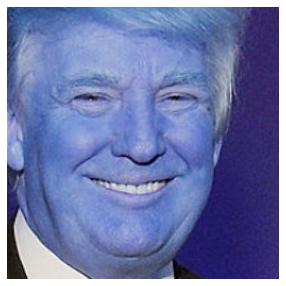

In [ ]:
display_images(image)

In [ ]:
image_pre = cv2.resize(image, dsize=(64, 64), interpolation=cv2.INTER_AREA)

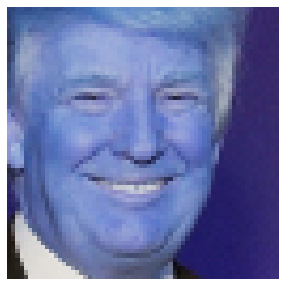

In [ ]:
display_images(image_pre)

In [ ]:
image_pre = tf.cast(image_pre, tf.float32)

In [ ]:
image_pre = (image_pre/255.0)

In [ ]:
image_pre = image_pre[None, ...]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


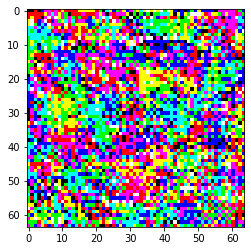

In [ ]:
FGSM = FastGradientSignMethod(model = model_AtoB)
adv_img, perturb = FGSM.create_adversarial_image(0.1, image_pre)

In [ ]:
import os
os.mkdir("../adv_output/")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


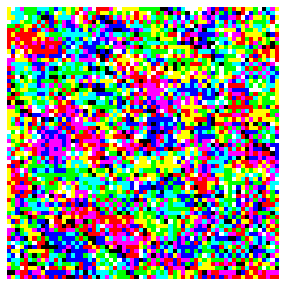

In [ ]:
display_images(perturb[0])
save_image(perturb, "perturb_eps0.05")

In [ ]:
adv_image_final = cv2.cvtColor(np.float32(adv_img[0]), cv2.COLOR_BGR2RGB)

In [ ]:
def save_image(image_numpy, title) : 
  image_numpy_arr = image_numpy*255
  image_numpy_arr = image_numpy_arr.astype(np.uint8)
  im = Image.fromarray(image_numpy_arr)
  im.save("../adv_output/{}.jpg".format(title))

In [ ]:
save_image(adv_image_final, "eps0.1_RGB")

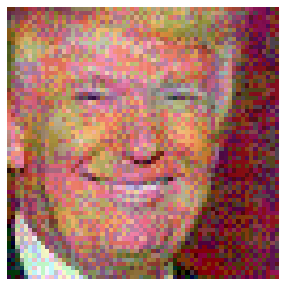

In [ ]:
display_images(adv_image_final)